In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [14]:
.
data = pd.read_csv('data.csv')
data = data.dropna()
data = data.iloc[:733,1:].values


In [15]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
scaled = sc.fit_transform(data)

In [16]:
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(len(train), len(test))

489 242


In [17]:
#convert an array of values into a dataset matrix
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(data[i + look_back, -1])
    return np.array(dataX), np.array(dataY)


In [18]:
# reshape into X=t and Y=t+1
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

print(X_test[2:5],"    ", y_test[2:5])

[[[27.2   0.   23.93]]

 [[26.9   0.   24.3 ]]

 [[27.7   0.   23.97]]]      [24.3  23.97 23.18]


In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [20]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 45, return_sequences = True, input_shape = (X_train.shape[1], 3)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer nd some Dropout regularisation
regressor.add(LSTM(units = 45, return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 80 , batch_size = 20)


Epoch 1/80
25/25 [==============================] - 4s 3ms/step - loss: 388.3749
Epoch 2/80
25/25 [==============================] - 0s 3ms/step - loss: 352.1515
Epoch 3/80
25/25 [==============================] - 0s 2ms/step - loss: 267.9393
Epoch 4/80
25/25 [==============================] - 0s 3ms/step - loss: 184.7300
Epoch 5/80
25/25 [==============================] - 0s 2ms/step - loss: 152.6021
Epoch 6/80
25/25 [==============================] - 0s 2ms/step - loss: 123.4650
Epoch 7/80
25/25 [==============================] - 0s 3ms/step - loss: 113.3067
Epoch 8/80
25/25 [==============================] - 0s 2ms/step - loss: 95.8878
Epoch 9/80
25/25 [==============================] - 0s 2ms/step - loss: 89.7546
Epoch 10/80
25/25 [==============================] - 0s 2ms/step - loss: 75.8705
Epoch 11/80
25/25 [==============================] - ETA: 0s - loss: 66.90 - 0s 3ms/step - loss: 67.0192
Epoch 12/80
25/25 [==============================] - 0s 2ms/step - loss: 63.7743
Epoch 

In [21]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 45)             8820      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 45)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 45)             16380     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 45)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              46        
Total params: 25,246
Trainable params: 25,246
Non-trainable params: 0
_________________________________________________________________


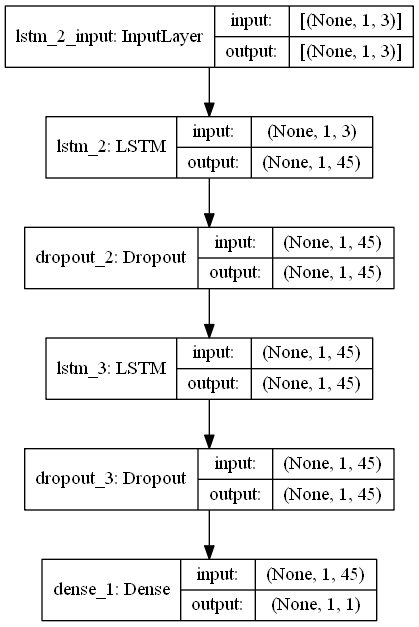

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(regressor, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
from sklearn.metrics import mean_squared_error
trainPredict = regressor.predict(X_train)
np.shape(trainPredict)
trainPredict = np.reshape(trainPredict, (487,1))
testPredict = regressor.predict(X_test)
testPredict = np.reshape(testPredict, (240,1))
trainScore = np.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 1.78 RMSE
Test Score: 2.74 RMSE


In [24]:
# ver_predict = regressor.predict(ver)

verification_data = [
[21.9,0.8,3.23],
[21.2,0,20.05],
[22.2,21.1,28.91],
[19.7,13.2,29.17],
[22.3,54.4,32.45],
[22.4,6.1,32.13]
]
verification_val = regressor.predict([verification_data])
verification_val = np.reshape(verification_val,(len(verification_data),1))
print(np.shape(verification_val))
actual_val = np.array([3.23,20.05,28.91,29.17,32.45,32.13])
actual_val = np.reshape(actual_val,(len(actual_val),1))
print(np.shape(actual_val))
vscore = np.sqrt(mean_squared_error(actual_val, verification_val))
vscore

(6, 1)
(6, 1)


4.880203715288975

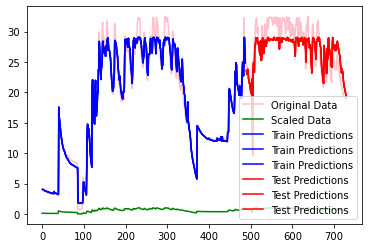

In [26]:
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict
# plot baseline and predictions
plt.plot(data[:,2],color="pink", label="Original Data")
plt.plot(scaled[:,-1],color="green", label="Scaled Data")
plt.plot(trainPredictPlot,color="blue", label="Train Predictions")
plt.plot(testPredictPlot, color="red", label="Test Predictions")
plt.legend(loc="upper left")
plt.show()


In [47]:
regressor.save("my_model.h5")


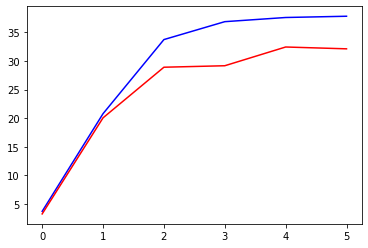

In [27]:
plt.plot(verification_val,color="blue")
plt.plot(actual_val, color="red")
plt.show()

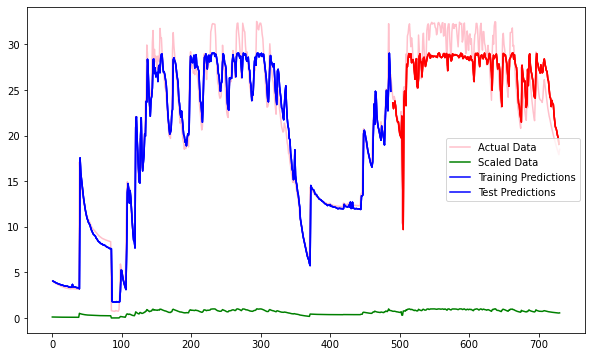

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# define data and plots

# set figure size
fig = plt.figure(figsize=(10,6))

# plot data
plt.plot(data[:,2], color="pink")
plt.plot(scaled[:,-1], color="green")
plt.plot(trainPredictPlot, color="blue")
plt.plot(testPredictPlot, color="red")

# add legend
plt.legend(['Actual Data', 'Scaled Data', 'Training Predictions', 'Test Predictions'])

# show plot
plt.show()
